In [ ]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow_datasets as tfds


In [ ]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'fashion_mnist',
    split=['train[:90%]', 'train[90%:]', 'test[:]'],
    with_info=True,
    as_supervised=True,
)




class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']



print(raw_train)
print(raw_validation)
print(raw_test)


<DatasetV1Adapter shapes: ((28, 28, 1), ()), types: (tf.uint8, tf.int64)>
<DatasetV1Adapter shapes: ((28, 28, 1), ()), types: (tf.uint8, tf.int64)>
<DatasetV1Adapter shapes: ((28, 28, 1), ()), types: (tf.uint8, tf.int64)>


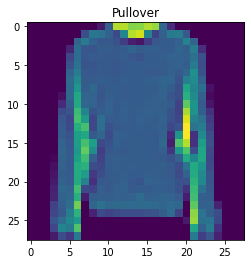

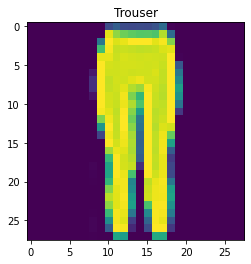

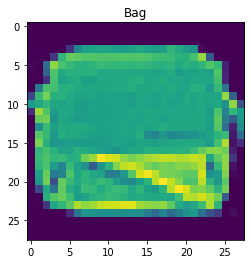

In [ ]:
get_label_name = metadata.features['label'].int2str

for image, label in raw_train.take(3):
  plt.figure()
  plt.imshow(np.squeeze(image))
  plt.title(get_label_name(label))

In [ ]:
IMG_SIZE = 28 # All images will be resized to 160x160

def format_example(image, label):
  image = tf.cast(image, tf.float32)
#   image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

In [ ]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)


In [ ]:
BATCH_SIZE = 24
SHUFFLE_BUFFER_SIZE = 1000

In [ ]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_batches = train_batches.prefetch(buffer_size=AUTOTUNE)
validation_batches = validation_batches.prefetch(buffer_size=AUTOTUNE)
test_batches = test_batches.prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

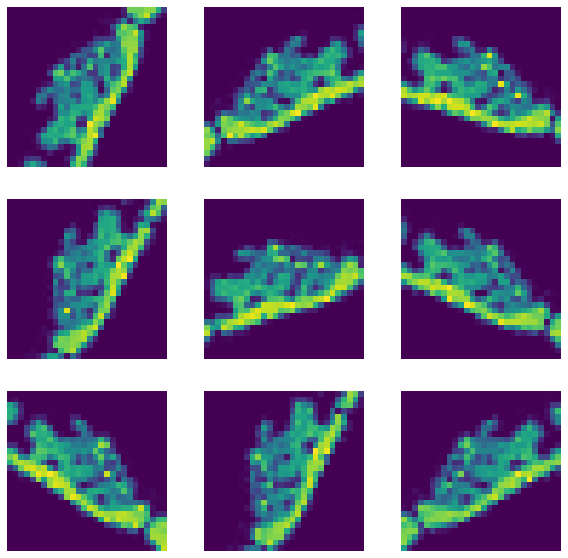

In [ ]:
for image, _ in train_batches.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(np.squeeze(augmented_image[0]) / 255)
    plt.axis('off')

In [ ]:
image_batch, label_batch = next(iter(train_batches))


In [ ]:
# #setup model
model = keras.Sequential([
    keras.layers.Conv2D( 32, kernel_size = (5,5),padding = 'Same',kernel_initializer='he_uniform', input_shape = (28,28,1)),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.Conv2D( 32, kernel_size = (5,5),padding = 'Same'),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.30),
    keras.layers.Conv2D(64, [3, 3],padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.Conv2D(64, [3, 3],padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.30),
    
    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.20),
    keras.layers.Dense(10, activation='softmax'),
    
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
batch_normalization_6 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
activation_4 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
batch_normalization_7 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
activation_5 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)       

In [ ]:
# adam = keras.optimizers.Adam(lr=0.0001, decay=1e-6)
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
history = model.fit(train_batches, epochs=10,validation_data=validation_batches)

Epoch 1/10
2250/2250 [==============================] - 24s 10ms/step - loss: 0.5052 - accuracy: 0.8216 - val_loss: 0.2885 - val_accuracy: 0.8960
Epoch 2/10
2250/2250 [==============================] - 23s 10ms/step - loss: 0.3408 - accuracy: 0.8766 - val_loss: 0.2939 - val_accuracy: 0.8985
Epoch 3/10
2250/2250 [==============================] - 23s 10ms/step - loss: 0.3025 - accuracy: 0.8895 - val_loss: 0.2818 - val_accuracy: 0.8910
Epoch 4/10
2250/2250 [==============================] - 23s 10ms/step - loss: 0.2706 - accuracy: 0.9015 - val_loss: 0.2340 - val_accuracy: 0.9150
Epoch 5/10
2250/2250 [==============================] - 23s 10ms/step - loss: 0.2471 - accuracy: 0.9095 - val_loss: 0.2230 - val_accuracy: 0.9185
Epoch 6/10
2250/2250 [==============================] - 24s 11ms/step - loss: 0.2298 - accuracy: 0.9164 - val_loss: 0.1998 - val_accuracy: 0.9282
Epoch 7/10
2250/2250 [==============================] - 24s 11ms/step - loss: 0.2153 - accuracy: 0.9228 - val_loss: 0.1885 -

In [ ]:
test_loss, test_acc = model.evaluate(test_batches, verbose=2)

print('Test accuracy:', test_acc)

417/417 - 2s - loss: 0.2079 - accuracy: 0.9244
Test accuracy: 0.9243999719619751


In [ ]:
predictions = model.predict(test_batches)

In [ ]:
print(predictions[0])


print(np.argmax(predictions[0]))

[1.9364486e-05 2.7298995e-06 5.2171610e-03 9.9115391e-07 9.1055655e-01
 2.1954195e-06 8.4196657e-02 2.6165155e-06 9.2467241e-07 7.9032765e-07]
4


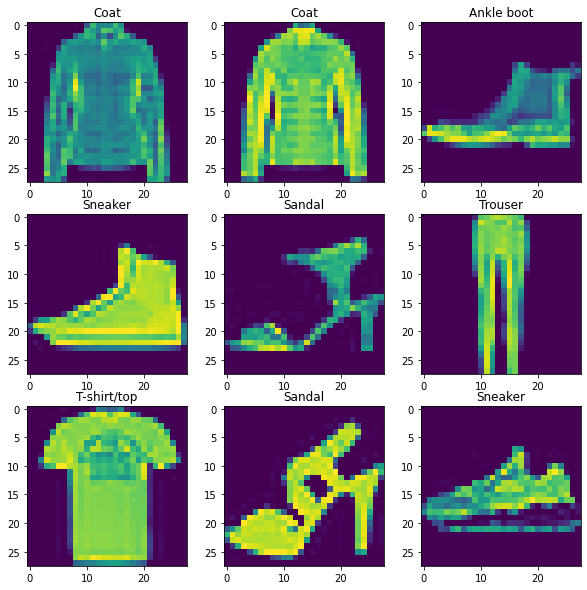

In [ ]:

plt.figure(figsize=(10, 10))
i=0
for image, label in raw_test.take(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(np.squeeze(image))
  plt.title(class_names[np.argmax(predictions[i])])
  plt.axis("on")
  i=i+1



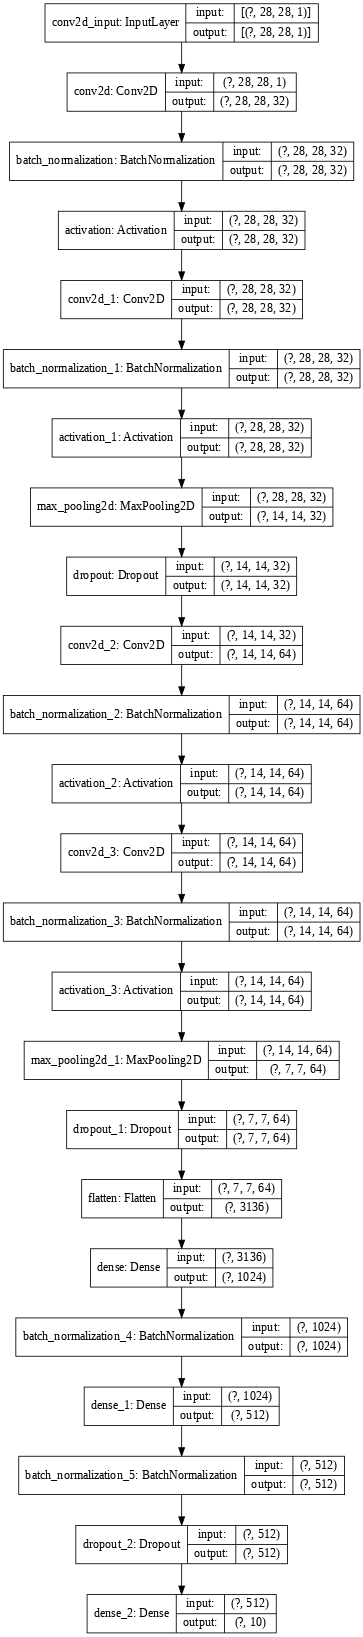

In [ ]:
tf.keras.utils.plot_model(model,show_shapes=True,dpi=60)
